This notebook provides some analysis snippets for extragalactic foregounds computation with `pysm3`



## Preamble



Matplotlib magic



In [1]:
%matplotlib inline

In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pysm
import pysm.units as u
print(" healpy :", hp.__version__)
print("  numpy :", np.__version__)
print("   pysm :", pysm.__version__)

 healpy : 1.13.0
  numpy : 1.18.1
   pysm : 3.1.dev262


## Getting started



This is a basic copy-paste of `pysm3` [tutorials](https://pysm3.readthedocs.io/en/latest/basic_use.html). Here we consider dust (`d1` model) and synchrotron (`s1`)
emission.



In [3]:
sky = pysm.Sky(nside=128, preset_strings=["d1", "s1"])
map_100GHz = sky.get_emission(100 * u.GHz)
print(map_100GHz[0, :3])

[1.8686613 1.9287539 2.237162 ] uK_RJ


We can convert unit to CMB µK



In [4]:
map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))
print(map_100GHz[0, :3])

[2.4042647 2.4815812 2.8783867] uK_CMB


We can also show the I, Q, U maps for the two different models



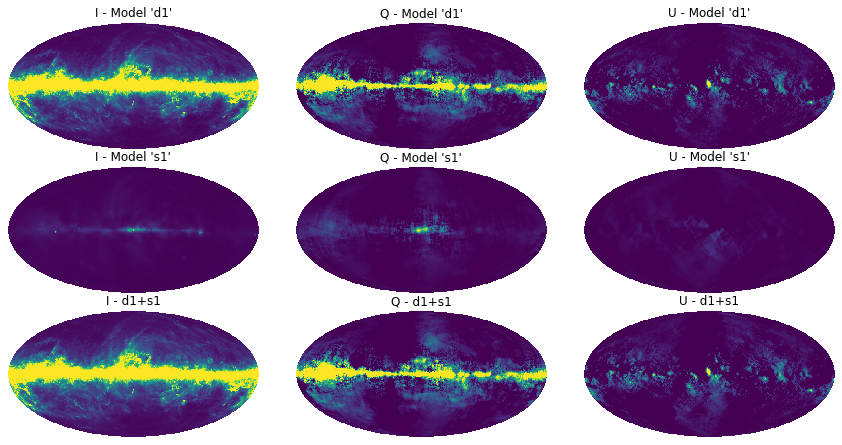

In [5]:
presets = ["d1", "s1"]
sky = pysm.Sky(nside=128, preset_strings=presets)

frequency = 100 * u.GHz
def µK_to_µCMB(sky_map):
  return sky_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(frequency))

sky_maps = {"Model '{}'".format(model):
            µK_to_µCMB(sky.components[i].get_emission(frequency))
            for i, model in enumerate(presets)}
sky_maps["+".join(presets)] = µK_to_µCMB(sky.get_emission(frequency))

plt.figure(figsize=(12, 6))
for i, (model, sky_map) in enumerate(sky_maps.items()):
    for j, spec in enumerate(["I", "Q", "U"]):
      vmin, vmax = 0, 100 if spec == "I" else 10
      hp.mollview(sky_map[j],
                  min=vmin, max=vmax,
                  cbar=False,
                  unit=sky_map.unit,
                  title="{} - {}".format(spec, model),
                  sub=(3, 3, 3*i+j+1))

We can finally plot the corresponding power spectra



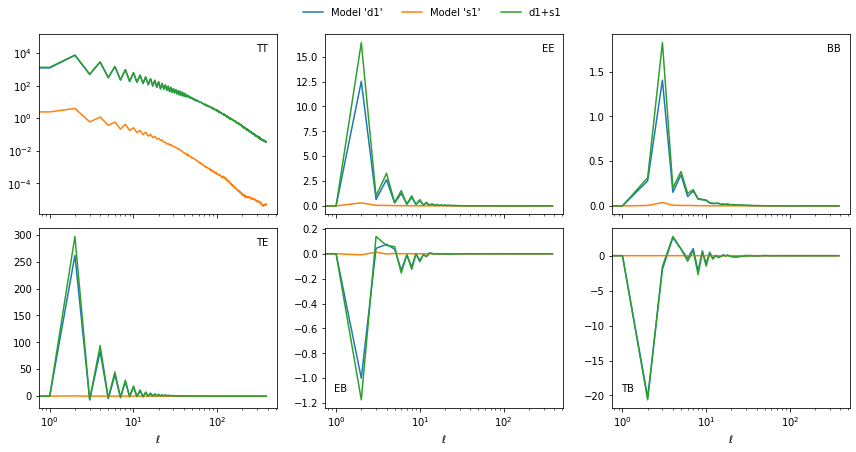

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axes = axes.flatten()

cls = {k: hp.anafast(v) for k, v in sky_maps.items()}
for k, v in cls.items():
    ell = np.arange(v.shape[1])
    for i, cl in enumerate(["TT", "EE", "BB", "TE", "EB", "TB"]):
        plot = axes[i].loglog if i == 0 else axes[i].semilogx
        plot(ell, v[i])
        axes[i].legend([], title=cl)
for ax in axes[3:]:
  ax.set_xlabel("$\ell$")
fig.legend(cls.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.tight_layout()

## Comparing models



### SO mask



First, we grab the galatic and the SO survey masks both in equatorian coordinates with `nside=1024`



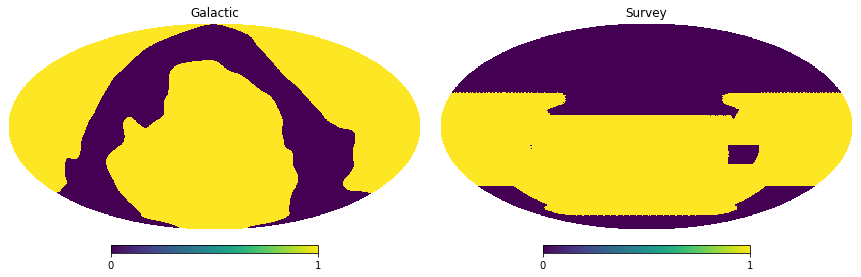

In [7]:
galactic_mask = np.load("./masks/mask_equatorial_1024.npz")["mask"]
survey_mask = np.load("./masks/survey_mask_1024.npz")["mask"]
plt.figure(figsize=(12, 4))
hp.mollview(galactic_mask, title="Galactic", sub=(1, 2, 1))
hp.mollview(survey_mask, title="Survey", sub=(1, 2, 2))

Since `pysm` generates maps in galactic coordinates and we do not want to rotate each of them, we
rotate the mask into galactic coordinates and apply 5 degrees smoothing



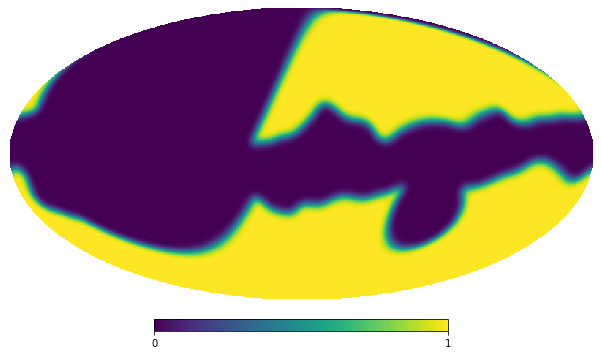

In [8]:
input_map = galactic_mask*survey_mask
mask = pysm.apply_smoothing_and_coord_transform(input_map,
                                                rot=hp.Rotator(coord="EG"),
                                                fwhm=5*u.deg)
hp.mollview(mask, title=None, min=0)

Let's try to mask the dust emission for instance and see the remnant emission at 100 GHz



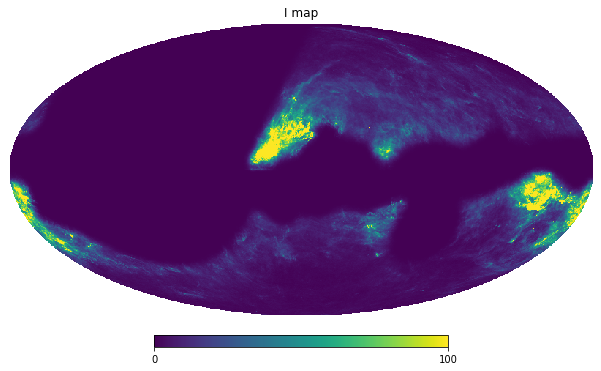

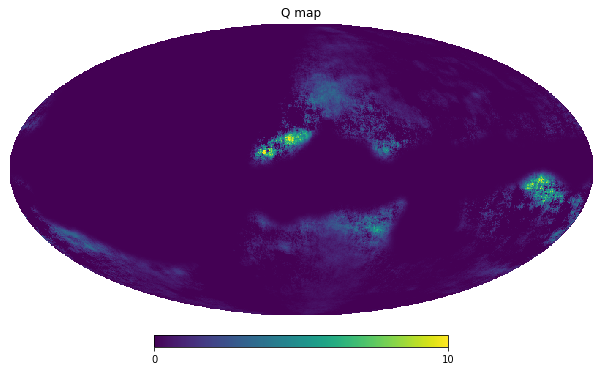

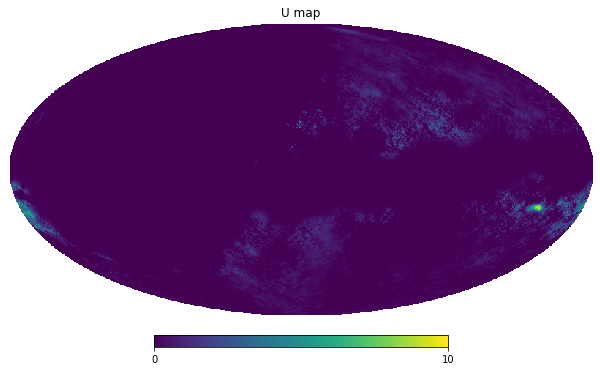

In [9]:
sky = pysm.Sky(nside=1024, preset_strings=["d1"], output_unit=u.uK_CMB)
map_100GHz = sky.get_emission(100 * u.GHz)
hp.mollview(mask * map_100GHz[0], min=0, max=100, title="I map")
hp.mollview(mask * map_100GHz[1], min=0, max=10, title="Q map")
hp.mollview(mask * map_100GHz[2], min=0, max=10, title="U map")

The corresponding $C_\ell$ are computed with `healpy.anafast` function



In [10]:
cls = hp.anafast(map_100GHz)

which looks like



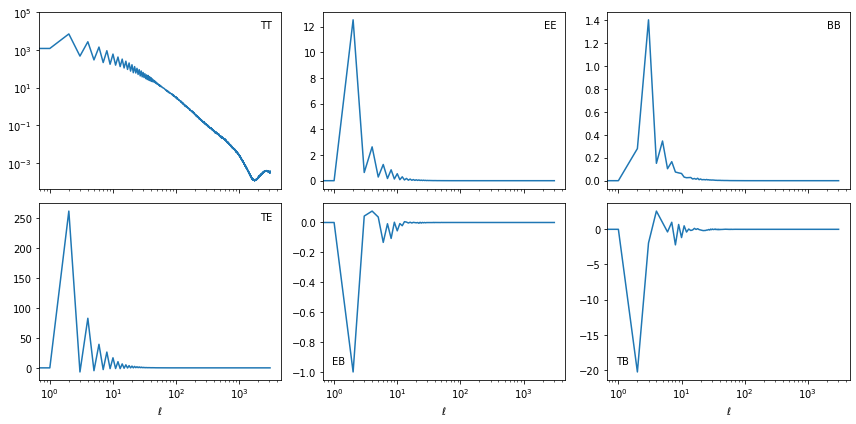

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axes = axes.flatten()

ell = np.arange(cls.shape[1])
for i, cl in enumerate(["TT", "EE", "BB", "TE", "EB", "TB"]):
    plot = axes[i].loglog if i == 0 else axes[i].semilogx
    plot(ell, cls[i])
    axes[i].legend([], title=cl)
for ax in axes[3:]:
  ax.set_xlabel("$\ell$")
plt.tight_layout()